Pipeline visant a tester le temps d'inférence en fonction de la longeur du texte/contexte donné a mrebel et de différents hyper paramètres afin d'obtenir le meilleur ensemble de performances.

In [ ]:
!pip install transformers torch

In [ ]:
import requests

# Replace 'your_pdf_url' with the actual URL of your PDF file
pdf_url = 'https://josephbeasse.fr/wp_202320_.pdf'

# Download the PDF
response = requests.get(pdf_url)

# Check if the download was successful
if response.status_code == 200:
    # Save the PDF to a local file in Colab
    with open('wp_202320_.pdf', 'wb') as file:
        file.write(response.content)
        print("PDF Downloaded.")

    # You can now work with the 'downloaded_pdf.pdf' file in your Colab notebook
else:
    print("Failed to download the PDF file.")

PDF Downloaded.


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import time


def enable_gpu(model, device):
    return model.to(device)


def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [ ]:
def generate_triplets(text, model, tokenizer, gen_kwargs, device):
    # Tokenize text
    model_inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    # Generate
    generated_tokens = model.generate(
        model_inputs["input_ids"],
        attention_mask=model_inputs["attention_mask"],
        **gen_kwargs,
    )

    # Extract text
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    triplets = []
    for idx, sentence in enumerate(decoded_preds):
        triplets.extend(extract_triplets(sentence))

    return triplets

In [ ]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
# NOTE: use Babelscape/mrebel-large for multilingual content
tokenizer = AutoTokenizer.from_pretrained("Babelscape/mrebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/mrebel-large")

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

In [ ]:
# Enable GPU
model = enable_gpu(model, device)

In [ ]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 18.2 MB/s eta 0:00:00


In [ ]:
import fitz
def extract_text_from_pdf(pdf_file_path, start_page=0, end_pages_to_skip=0):
    try:
        doc = fitz.open(pdf_file_path)
        text = ""
        total_pages = doc.page_count
        for page_num in range(start_page, total_pages - end_pages_to_skip):
            if page_num < start_page:
                continue
            page = doc.load_page(page_num)
            text += page.get_text()
        return text
    except Exception as e:
        return str(e)

In [ ]:
def process_long_text(text, model, tokenizer, gen_kwargs, device):
    max_length = gen_kwargs["max_length"]
    triplets = []

    # Split the text into segments
    segments = [text[i:i+max_length] for i in range(0, len(text), max_length)]
    i = 0
    for segment in segments:
        print(f"Segment {i}")
        start = time.time()
        triplet = generate_triplets(segment, model, tokenizer, gen_kwargs, device)
        print(triplet)
        print(f"Time elapsed for segment: {time.time()-start}")
        triplets.extend(triplet)
        i += 1
    return triplets

In [ ]:
text = extract_text_from_pdf('wp_202320_.pdf',start_page=2,end_pages_to_skip=15)

In [ ]:
# Tune the model's hyperparameters
def get_kwargs(length, sequences):
  gen_kwargs = {
      "max_length": length,
      "length_penalty": 0,
      "num_beams": sequences,
      "num_return_sequences": sequences,
  }
  return gen_kwargs

______________________________________

--------------

In [ ]:
lengths = [128, 256, 512, 1024, 2048, 4096]
sequences = [2, 5, 10, 20]
elapsed_times = []
parameter_combinations = []

# Iterate over the lengths and sequences
for length in lengths:
    print("Length: ", length, " started")
    for sequence in sequences:
        print("Sequence: ", sequence, " started")
        # Generate or load the 'text' variable here if needed
        start = time.time()
        triplets = process_long_text(text, model, tokenizer, get_kwargs(length, sequence), device)
        end = time.time()
        elapsed_time = end - start
        elapsed_times.append(elapsed_time)
        parameter_combinations.append((length, sequence))

Length:  128  started
Sequence:  2  started
Sequence:  5  started
Sequence:  10  started
Sequence:  20  started
Length:  256  started
Sequence:  2  started
Sequence:  5  started
Sequence:  10  started
Sequence:  20  started
Length:  512  started
Sequence:  2  started
Sequence:  5  started
Sequence:  10  started
Sequence:  20  started
Length:  1024  started
Sequence:  2  started
Sequence:  5  started
Sequence:  10  started
Sequence:  20  started
Length:  2048  started
Sequence:  2  started
Sequence:  5  started
Sequence:  10  started
Sequence:  20  started
Length:  4096  started
Sequence:  2  started
Sequence:  5  started
Sequence:  10  started
Sequence:  20  started


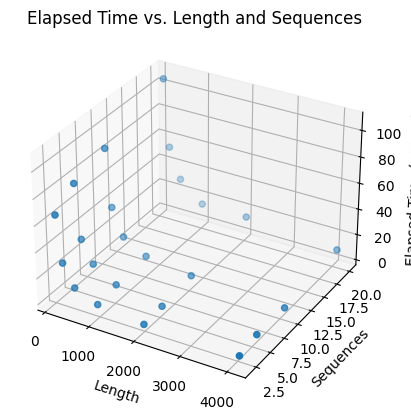

In [ ]:
import matplotlib.pyplot as plt

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract the lengths and sequences from parameter_combinations
lengths, sequences = zip(*parameter_combinations)

# Plot the elapsed times against lengths and sequences
ax.scatter(lengths, sequences, elapsed_times)

# Customize labels and title
ax.set_xlabel('Length')
ax.set_ylabel('Sequences')
ax.set_zlabel('Elapsed Time (seconds)')
plt.title('Elapsed Time vs. Length and Sequences')

# Show the plot
plt.show()

In [ ]:
!pip install pandas seaborn

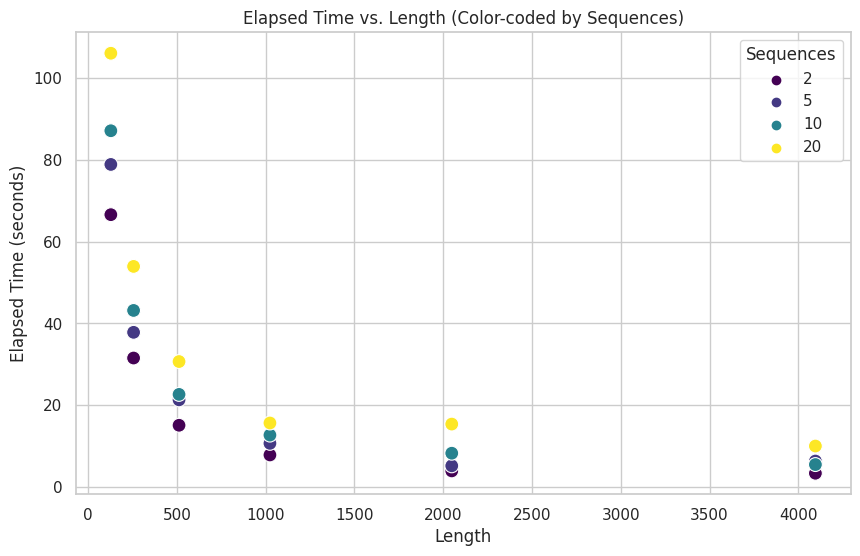

In [ ]:
import pandas as pd
import seaborn as sns

# Create a Pandas DataFrame
data = pd.DataFrame({
    'Length': lengths,
    'Sequences': sequences,
    'Elapsed Time (seconds)': elapsed_times
})

# Create a more refined plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Length", y="Elapsed Time (seconds)", hue="Sequences", data=data, palette="viridis", s=100)

# Customize labels and title
plt.xlabel("Length")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Elapsed Time vs. Length (Color-coded by Sequences)")

# Show the plot
plt.show()